<a href="https://colab.research.google.com/github/lukeolson/imperial-multigrid/blob/master/lecture-1-mg-basics/6-multigrid-two-level.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import scipy as sp
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg as sla
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')

%matplotlib inline

### norm

First create a *grid* norm, something that calculates the L2 norm on our domain.

In [2]:
def hnorm(r):
    """define ||r||_h = h ||r||_2"""
    n = len(r)
    h = 1.0 / (n+1)
    hrnorm = h * np.linalg.norm(r)
    return hrnorm

### poisson

construct a poisson operator

In [3]:
def poissonop(n):
    A = (n+1)**2 * sparse.diags([-1, 2, -1], [-1, 0, 1], shape=(n,n), format='csr')
    return A

print(poissonop(5).toarray() / 36)

[[ 2. -1.  0.  0.  0.]
 [-1.  2. -1.  0.  0.]
 [ 0. -1.  2. -1.  0.]
 [ 0.  0. -1.  2. -1.]
 [ 0.  0.  0. -1.  2.]]


### relaxation

Try weighted Jacobi with $\omega = 2/3$

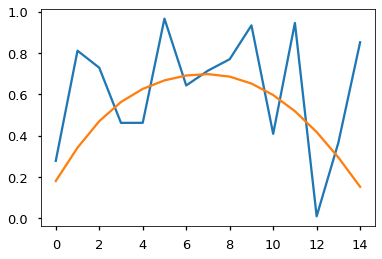

In [4]:
def relax(A, u, f, nu):
    n = A.shape[0]
    Dinv = 1.0 / (2.0 * (n+1)**2)
    omega = 2.0 / 3.0
    for steps in range(nu):
        u += omega * Dinv * (f - A * u)
        
A = poissonop(15)
u = np.random.rand(15)
f = np.zeros(15)
uinit = u.copy()
relax(A, u, f, 10)
plt.plot(uinit)
plt.plot(u)

### interpolation / restriction

Interpolation and restriction can be done in place

In [5]:
def interpolate(uc):
    """interpolate u of size 2**(k-1)-1 to 2**(k)-1"""
    nc = len(uc)
    nf = 2**(int(np.log2(nc+1))+1)-1
    uf = np.zeros((nf,))
    I = np.arange(1,nf,2)
    uf[I-1] = 0.5 * uc
    uf[I] = uc
    uf[I+1] += 0.5 * uc
    return uf

def restrict(uf):
    """restrict u of size 2**(k)-1 to 2**(k-1)-1"""
    nf = len(uf)
    nc = 2**(int(np.log2(nf+1))-1)-1
    uc = np.zeros((nc,))
    I = np.arange(1,nf,2)
    uc = 0.25 * uf[I-1] + 0.5 * uf[I] + 0.25 * uf[I+1]
    return uc

(0.0, 1.0, 0.0, 1.0)

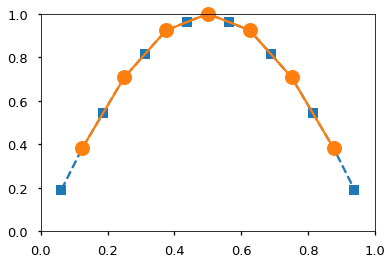

In [6]:
k=4
nc = 2**(k-1)-1
nf = 2**(k)-1
xc = np.linspace(0,1,nc+2)[1:-1]
xf = np.linspace(0,1,nf+2)[1:-1]

uc = np.sin(xc*np.pi)
uf = interpolate(uc)

plt.plot(xf, uf, '--s')
plt.plot(xc, uc, '-o', clip_on=False, ms=15)
plt.axis([0,1,0,1])

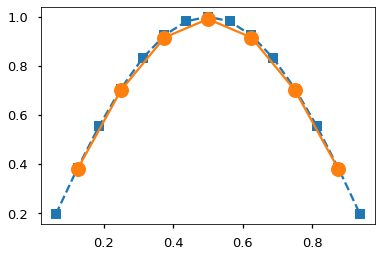

In [7]:
uf = np.sin(xf*np.pi)
uc = restrict(uf)

plt.plot(xf, uf, '--s')
plt.plot(xc, uc, '-o', ms=15)

## Set up a problem

Let's use a random solution.

size = 127


Text(0, 0.5, '$u(x)$')

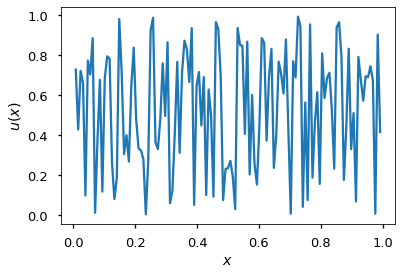

In [9]:
k = 7
n = 2**k - 1
print("size = %d" % n)
u = np.random.rand(n)
xx = np.linspace(0,1,n+2)[1:-1]

#f = np.random.rand(n)#np.pi**2 * np.sin(np.pi*xx)
A = poissonop(n)
f = A * np.random.rand(n)
ustar = sla.spsolve(A, f) 

plt.plot(xx, ustar)
plt.xlabel(r'$x$')
plt.ylabel(r'$u(x)$')

### Try one cycle...

starting residual:  0.0001798170854601273
starting error:  8.994274821156475e-09
  ending residual:  1.997967616888402e-05
  ending error:  9.9936440006398e-10


Text(0, 0.5, '$u(x)$')

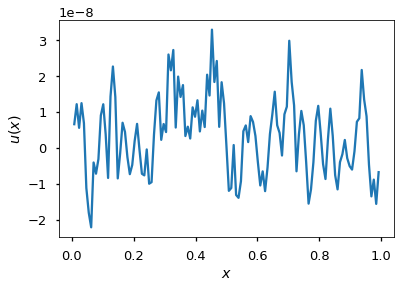

In [17]:
print('starting residual: ', hnorm(f - A * u))
print('starting error: ', hnorm(u - ustar))
relax(A, u, f, 1)
rc = restrict(f - A * u)
Ac = poissonop(len(rc))
ec = sparse.linalg.spsolve(Ac, rc)
ef = interpolate(ec)
u = u + ef
relax(A, u, f, 1)
print('  ending residual: ', hnorm(f - A * u))
print('  ending error: ', hnorm(u - ustar))
plt.plot(xx, u-ustar)
plt.xlabel(r'$x$')
plt.ylabel(r'$u(x)$')

### Now try many cycles...

In [18]:
u = np.random.rand(n)

res = [hnorm(f - A * u)]

print("res[0] = %g"%res[-1])
for cycle in range(10):
    relax(A, u, f, 1)
    rc = restrict(f - A * u)
    ec = sparse.linalg.spsolve(poissonop(len(rc)), rc)
    ef = interpolate(ec)
    u = u + ef
    relax(A, u, f, 1)
    res.append(hnorm(f - A * u))
    print("res[%d] = %g"%(cycle+1,res[-1]))

res[0] = 1507.01
res[1] = 104.55
res[2] = 11.6166
res[3] = 1.29074
res[4] = 0.143415
res[5] = 0.015935
res[6] = 0.00177056
res[7] = 0.000196729
res[8] = 2.18588e-05
res[9] = 2.42875e-06
res[10] = 2.69861e-07


In [19]:
res = np.array(res)
res[1:]/res[:-1]

array([0.06937549, 0.11111111, 0.11111111, 0.11111111, 0.11111111,
       0.11111111, 0.11111111, 0.11111111, 0.11111111, 0.11111112])

In [20]:
1/3 * 1/3

0.1111111111111111